In [61]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import timeit
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
from gensim import models
from gensim.models import KeyedVectors
import gensim.downloader as api

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score


[nltk_data] Downloading package stopwords to C:\Users\Sowmya
[nltk_data]     Sivakumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sowmya
[nltk_data]     Sivakumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#import files
train_data = pd.read_csv('train.csv', usecols =['utterance','context'])
valid_data = pd.read_csv('valid.csv', usecols =['utterance','context'])
test_data = pd.read_csv('test.csv',usecols =['utterance','context'])


In [3]:
#filter out only {sad, joyful,jealous, terrified}
train_data_list_filtered = train_data[train_data['context'].isin(['sad','jealous','joyful','terrified'])]
valid_data_list_filtered = valid_data[valid_data['context'].isin(['sad','jealous','joyful','terrified'])]
test_data_list_filtered = test_data[test_data['context'].isin(['sad','jealous','joyful','terrified'])]

In [4]:
#encoding training labels 
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_data_list_filtered['context'])

#encode test labels 
test_labels_encoded = encoder.transform(test_data_list_filtered['context'])

labels_dict = dict(list(zip([0,1,2,3],encoder.inverse_transform([0,1,2,3]))))

In [5]:
train_data_list = train_data_list_filtered['utterance']
valid_data_list = valid_data_list_filtered['utterance']
test_data_list = test_data_list_filtered['utterance']


### Data Preprocessing
#### 1.Bag of Words Representation

In [6]:
#Bag of Words Representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_data_list)
encoding = X.toarray()

#counting words that are greater than zero(since Bag of Words tends to give sparse representations)
nonzero_counts = np.count_nonzero(encoding)
nonzero_percentage = nonzero_counts/encoding.size

print("Array size : {0}".format(encoding.size))
print("Non-zero counts : {0}".format(nonzero_counts))
print("Percentage : {0}".format(nonzero_percentage))

Array size : 87516601
Non-zero counts : 117669
Percentage : 0.0013445334788539148


#### Shortcoming of this representation of features is that :
- They can be very sparse. As shown above, only 0.13% of the table is populated. The table size can get very large and not give enough information, if we take the size of the table into consideration.
- They do not take into account the order/context of the words. 

In [7]:
#removal of stop words 
stopwords = list(set(stopwords.words('english')))
stopwords.extend(['_comma_', ''])  
train_data_list_cleaned = train_data_list.apply(lambda x: [w for w in word_tokenize(x) if not w.lower() in stopwords])
train_data_list_cleaned_fnl = train_data_list_cleaned.str.join(' ')

test_data_list_cleaned = test_data_list.apply(lambda x: [w for w in word_tokenize(x) if not w.lower() in stopwords])
test_data_list_cleaned_fnl = test_data_list_cleaned.str.join(' ')

#Convert to Bag of Words now and check Sparsity
#Bag of Words Representation
vectorizer = CountVectorizer()
train_data_bow = vectorizer.fit_transform(train_data_list_cleaned_fnl)
train_data_BoW_arr = train_data_bow.toarray()

#counting words that are greater than zero(since Bag of Words tends to give sparse representations)
nonzero_counts = np.count_nonzero(train_data_BoW_arr)
nonzero_percentage = nonzero_counts/train_data_BoW_arr.size

print("Array size : {0}".format(train_data_BoW_arr.size))
print("Non-zero counts : {0}".format(nonzero_counts))
print("Percentage : {0}".format(nonzero_percentage))

Array size : 86840608
Non-zero counts : 64604
Percentage : 0.000743937674872106


#### 2. TF-IDF Normalization

In [8]:
#training data
train_tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
train_data_tfidf_transformed = train_tfidf_transformer.fit_transform(train_data_bow)
train_data_tfidf = train_data_tfidf_transformed.toarray()      


In [9]:
#check how the transformation looks 
print(train_data_tfidf.shape)

df = pd.DataFrame(train_data_tfidf_transformed[0].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

(9797, 8864)
                       TF-IDF
bullets_comma_       0.375423
microscope           0.375423
sweat                0.348022
uncomfortable        0.339201
interviews           0.339201
general              0.320621
looked               0.278873
makes                0.214568
job                  0.209205
make                 0.196670
always               0.185675
like                 0.152812
overlooking          0.000000
overhwleming         0.000000
overjoyed            0.000000
overqualified        0.000000
overnight_comma_     0.000000
overprotective       0.000000
overreacting_comma_  0.000000
overshares           0.000000
overthinking         0.000000
overheated           0.000000
overeating           0.000000
overflow             0.000000
overtrusted          0.000000


#### 3.Building an SGD Classifier for Multi-Class classification

In [10]:
X_train = train_data_tfidf_transformed
y_train = train_labels_encoded
model = SGDClassifier(loss = 'log')
model.fit(X_train,y_train)



SGDClassifier(loss='log')

In [11]:
#testdata transformation using training data
test_data_bow = vectorizer.transform(test_data_list_cleaned_fnl)
test_data_BoW_arr = test_data_bow.toarray()

test_data_tfidf_transformed = train_tfidf_transformer.transform(test_data_bow)
test_data_tfidf = test_data_tfidf_transformed.toarray()      

In [12]:
#perform predictions
X_test = test_data_tfidf_transformed
y_pred = model.predict(X_test)
y_test = test_labels_encoded

Accuracy : 0.6194625998547567
F-score : 0.6194625998547567


<AxesSubplot:>

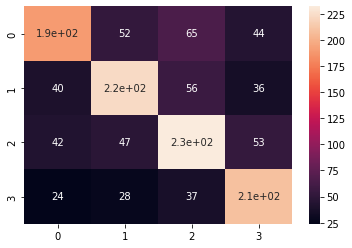

In [13]:
accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average = 'micro')
cf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy : {0}\nF-score : {1}".format(accuracy,f1_score))
sns.heatmap(cf_matrix, annot=True)

#### 4. Using Word2Vec Embeddings (Google Word2Vec)

In [27]:
#download the model and return as object ready for use
model = api.load("word2vec-google-news-300") 

#check model size
model.vector_size

300

#### To get the vector for each training instance, we will take a weighted avg of all the word-vectors for that instance, weighted on the number of occurences of the word. 

For example, "This is a cat without a tail" would be converted as :
            docVector = 1/7 [1(wv(this)) + 1(wv(is)) + 2(wv(a)) + 1(wv(cat)) + 1(wv(without)) + 1(wv(tail))]

Steps : 
1. Filter out the word vector for the words present in the training instances
2. Convert each instance to a doc vec based on following steps :
    - Get list of unique words in the instance 
    - Get the occurence of each unique word
    - Get vectors corresponding to each word
    - Do a weighted avg with the weights as the number of occurences 
3. Repeat for all instances of training data

In [73]:
def doc2vec(doc):
    
    docWords = [word for word in doc if word in list(model.index_to_key)] # check if word is in vocab
    if len(docWords)!=0 :
        modelVectorDict = {word:model[word] for word in docWords} # word : Vector
        uniqueWords, wordCounts = np.unique(docWords, return_counts = True) 
        wordCountDict = dict(zip( uniqueWords, wordCounts)) #word : Number of occurences

        modelVectorDict =  dict(sorted(modelVectorDict.items()))
        wordCountDict =  dict(sorted(wordCountDict.items()))
        wordVectors = np.array(list(modelVectorDict.values()))

        docVec = np.average(wordVectors,axis=0, weights = list(wordCountDict.values()))
        return docVec
    else: 
        return None
    

    

In [74]:
start = timeit.timeit()
Doc2Vec = train_data_list_cleaned_fnl.apply(lambda doc: doc2vec(word_tokenize(doc)))
end = timeit.timeit()

print(end - start)

    


KeyboardInterrupt: 